In [1]:
import os
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models, transforms
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import matplotlib.pyplot as plt
import random

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:
class LensDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.classes = ["no", "sphere", "vort"]
        self.image_paths = []
        self.labels = []
        
        for label, class_name in enumerate(self.classes):
            class_dir = os.path.join(root_dir, class_name)
            for file in os.listdir(class_dir):
                if file.endswith('.npy'):
                    self.image_paths.append(os.path.join(class_dir, file))
                    self.labels.append(label)

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image_path = self.image_paths[idx]
        label = self.labels[idx]
        
        image = np.load(image_path).astype(np.float32)
        
        # Ensure the image has 2D or 3D shape compatible with PyTorch
        if image.ndim == 2:  # Grayscale image
            image = np.stack([image] * 3, axis=0)  # Convert to 3 channels (C, H, W)
        elif image.ndim == 3 and image.shape[0] == 1:  # Single-channel image
            image = np.squeeze(image, axis=0)  # Remove the extra channel dimension
            image = np.stack([image] * 3, axis=0)  # Convert to 3 channels
        
        if self.transform:
            image = torch.tensor(image)  # Convert to tensor
            image = self.transform(image)  # Apply transformations
        
        return image.to(device), torch.tensor(label, dtype=torch.long, device=device)

In [ ]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize for DenseNet/ResNet
    transforms.RandomHorizontalFlip(),
    # transforms.ToTensor()
])

# Load train and validation datasets
val_dataset = LensDataset(r"D:\my_study\GSOC\dataset\dataset\val", transform=transform)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

In [5]:
densenet = models.densenet161(pretrained=False)
resnet = models.resnet18(pretrained=False)

# Modify the classifier for 3 classes
densenet.classifier = nn.Sequential(
    nn.Linear(2208, 1024),
    nn.ReLU(),
    nn.BatchNorm1d(1024),
    nn.Dropout(p=0.33),
    nn.Linear(1024, 64),
    nn.ReLU(),
    nn.BatchNorm1d(64),
    nn.Dropout(p=0.33),
    nn.Linear(64, 3)
)

resnet.fc = nn.Sequential(
    nn.Linear(resnet.fc.in_features, 1024),
    nn.ReLU(),
    nn.BatchNorm1d(1024),
    nn.Dropout(p=0.33),
    nn.Linear(1024, 64),
    nn.ReLU(),
    nn.BatchNorm1d(64),
    nn.Dropout(p=0.33),
    nn.Linear(64, 3)
)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


In [6]:
class EnsembleModel(nn.Module):
    def __init__(self, model1, model2):
        super(EnsembleModel, self).__init__()
        self.model1 = model1
        self.model2 = model2

    def forward(self, x):
        out1 = self.model1(x)
        out2 = self.model2(x)
        return (out1 + out2) / 2  # Averaging predictions

# Create ensemble model
ensemble_model = EnsembleModel(densenet, resnet).to(device)

Accuracy: 95.92%


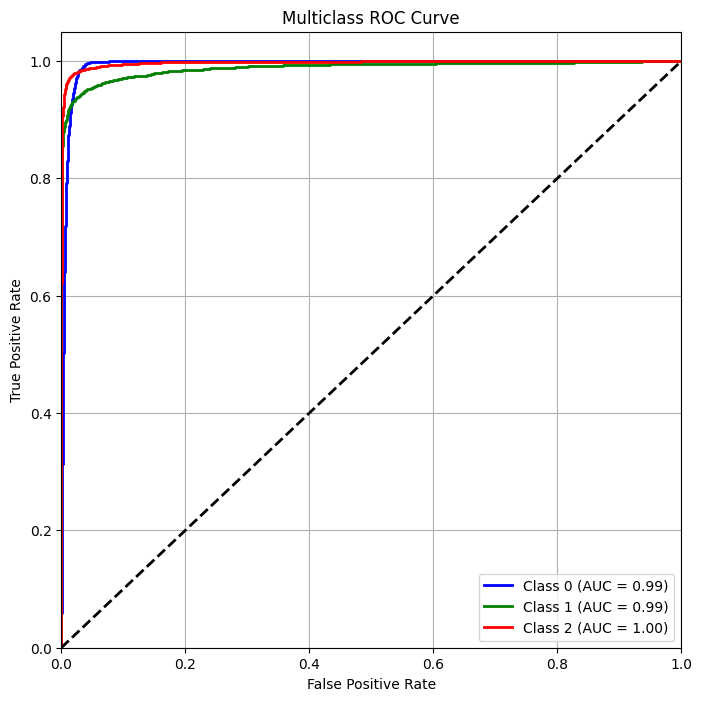

In [ ]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc, accuracy_score
from sklearn.preprocessing import label_binarize
from itertools import cycle

def plot_multiclass_roc(y_true, y_scores, n_classes, title="Multiclass ROC Curve"):
    # Binarize the labels for multiclass ROC
    y_true_bin = label_binarize(y_true, classes=np.arange(n_classes))

    plt.figure(figsize=(8, 8))
    colors = cycle(['blue', 'green', 'red', 'orange', 'purple', 'brown', 'pink', 'cyan'])

    for i, color in zip(range(n_classes), colors):
        fpr, tpr, _ = roc_curve(y_true_bin[:, i], y_scores[:, i])
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, color=color, lw=2, label=f'Class {i} (AUC = {roc_auc:.2f})')

    plt.plot([0, 1], [0, 1], 'k--', lw=2)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(title)
    plt.legend(loc="lower right")
    plt.grid(True)
    plt.show()

def evaluate_model(model, val_loader, device):
    model.eval()
    all_preds = []
    all_labels = []
    
    val_correct, val_total = 0, 0
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = model(inputs)
            val_correct += (outputs.argmax(1) == labels).sum().item()
            val_total += labels.size(0)
            probs = torch.softmax(outputs, dim=1)  # Get probabilities
            preds = outputs.argmax(1)    # Get predicted classes

            all_preds.append(probs.cpu().numpy())
            all_labels.append(labels.cpu().numpy())

    y_scores = np.vstack(all_preds)         # Predicted probabilities
    y_true = np.concatenate(all_labels)     # Actual labels

    # Calculate accuracy
    y_pred = np.argmax(y_scores, axis=1)    # Predicted labels from probabilities
    val_acc = val_correct / val_total

    print(f"Accuracy: {val_acc * 100:.2f}%")
    return y_true, y_scores

# Configuration
model_path = r'D:\my_study\GSOC\models\Ensemble_epoch14.pth'  # Path to saved model weights
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Load model (replace with your model definition)
ensemble_model.load_state_dict(torch.load(model_path))
ensemble_model.to(device)

# Evaluate the model using validation data
y_true, y_scores = evaluate_model(ensemble_model, val_loader, device)

# Determine the number of classes from predictions
n_classes = y_scores.shape[1]

# Plot the ROC curve for multiclass classification
plot_multiclass_roc(y_true, y_scores, n_classes)


<ipython-input-24-63aadfb985a0>:64: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  densenet.load_state_dict(torch.load(model_path))


Accuracy: 89.21%


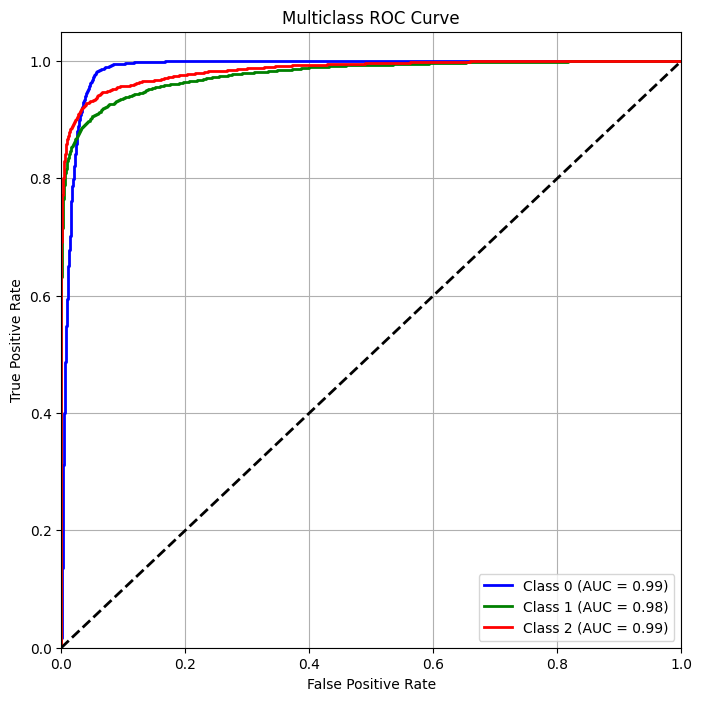

In [ ]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc, accuracy_score
from sklearn.preprocessing import label_binarize
from itertools import cycle

def plot_multiclass_roc(y_true, y_scores, n_classes, title="Multiclass ROC Curve"):
    # Binarize the labels for multiclass ROC
    y_true_bin = label_binarize(y_true, classes=np.arange(n_classes))

    plt.figure(figsize=(8, 8))
    colors = cycle(['blue', 'green', 'red', 'orange', 'purple', 'brown', 'pink', 'cyan'])

    for i, color in zip(range(n_classes), colors):
        fpr, tpr, _ = roc_curve(y_true_bin[:, i], y_scores[:, i])
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, color=color, lw=2, label=f'Class {i} (AUC = {roc_auc:.2f})')

    plt.plot([0, 1], [0, 1], 'k--', lw=2)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(title)
    plt.legend(loc="lower right")
    plt.grid(True)
    plt.show()

def evaluate_model(model, val_loader, device):
    model.eval()
    all_preds = []
    all_labels = []
    
    val_correct, val_total = 0, 0
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = model(inputs)
            val_correct += (outputs.argmax(1) == labels).sum().item()
            val_total += labels.size(0)
            probs = torch.softmax(outputs, dim=1)  # Get probabilities
            preds = outputs.argmax(1)    # Get predicted classes

            all_preds.append(probs.cpu().numpy())
            all_labels.append(labels.cpu().numpy())

    y_scores = np.vstack(all_preds)         # Predicted probabilities
    y_true = np.concatenate(all_labels)     # Actual labels

    # Calculate accuracy
    y_pred = np.argmax(y_scores, axis=1)    # Predicted labels from probabilities
    val_acc = val_correct / val_total

    print(f"Accuracy: {val_acc * 100:.2f}%")
    return y_true, y_scores

# Configuration
model_path = r'models\DenseNet_features_early_epoch8.pth'  # Path to saved model weights
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Load model (replace with your model definition)
densenet.load_state_dict(torch.load(model_path))
densenet.to(device)

# Evaluate the model using validation data
y_true, y_scores = evaluate_model(densenet, val_loader, device)

# Determine the number of classes from predictions
n_classes = y_scores.shape[1]

# Plot the ROC curve for multiclass classification
plot_multiclass_roc(y_true, y_scores, n_classes)
